In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Rectangle
from matplotlib import cm


In [32]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
else:
    print("CUDA (GPU support) is not available in PyTorch.")

CUDA (GPU support) is available in PyTorch!


In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class Puasson1DPINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(Puasson1DPINN, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(in_features=layers[i], out_features=layers[i+1]) 
            for i in range(len(layers)-1)
        ])
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('tanh'))
        self.optimizer = optimizer
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x)
        return x

    def forward_pass_with_grad(self, x):
        x.requires_grad_(True)
        
        u = self.forward(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x_x = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        return u, u_x_x

    def dirichlet_condition(self, x_bc_left_right, u_bc_left_right):
        u, _ = self.forward_pass_with_grad(x_bc_left_right)
        return torch.mean((u - u_bc_left_right) ** 2)

    def loss_fn(self, u_x_x, x_train, x_bc_left_right, u_bc_left_right):
        puasson_eq = u_x_x - self.f(x_train)
        bc_dirichlet_left_right = self.dirichlet_condition(x_bc_left_right, u_bc_left_right)
        return torch.mean(puasson_eq ** 2) + bc_dirichlet_left_right
    
    def train(self, loss_threshold, x_train, x_bc_left_right, u_bc_left_right):
        loss_array = []
        start_time = time.time()
        loss = torch.tensor(1.0)
        epoch = 0

        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            _, u_x_x = self.forward_pass_with_grad(x_train)
            loss = self.loss_fn(u_x_x, x_train, x_bc_left_right, u_bc_left_right)
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss')
        plt.savefig("1d_poisson_equation_training_pytorch.png")
        plt.show(block=False)

    def f(self, x):
        return -np.pi * torch.sin(np.pi * x)

    def exact_solution(self, x):
        return torch.sin(np.pi * x) / np.pi

Epoch 0, Loss: 9.517556190490723
Epoch 100, Loss: 0.02003648318350315
Epoch 200, Loss: 0.010542879812419415
Epoch 300, Loss: 0.004306351765990257
Epoch 400, Loss: 0.002355355303734541
Epoch 500, Loss: 0.00178874924313277
Epoch 600, Loss: 0.0013917656615376472
Epoch 700, Loss: 0.0010732734808698297
Training took 2.2329578399658203 seconds
Last epoch: 728, loss: 0.0009987448574975133


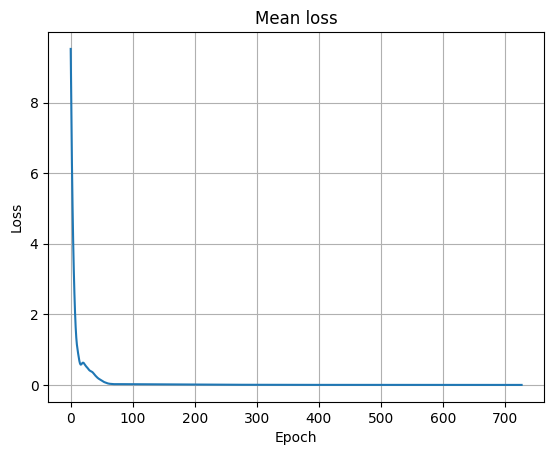

In [4]:
# Setup training and test data configurations
N_of_train_points_1D = 10
N_of_test_points_1D = 101
L_x_1D = 0.0
R_x_1D = 1.0
Dirichlet_left_1D = 0.0
Dirichlet_right_1D = 0.0
loss_threshold_1D = 0.001
Layers_1D = [1, 10, 10, 10, 1] # Adjusted to include input and output layers explicitly
Learning_rate_1D = 0.005

# Prepare the model
model_1D = Puasson1DPINN(Layers_1D, None) # Optimizer will be set up separately in PyTorch

# Setup the optimizer
optimizer_1D = optim.Adam(model_1D.parameters(), lr=Learning_rate_1D)

# Assign the optimizer to the model (if the model class uses it)
model_1D.optimizer = optimizer_1D

# Prepare training and boundary condition data
x_train_1D = torch.linspace(L_x_1D, R_x_1D, N_of_train_points_1D).unsqueeze(-1).float()
x_bc_left_right_1D = torch.tensor([L_x_1D, R_x_1D]).unsqueeze(-1).float()
u_bc_left_right_1D = torch.tensor([Dirichlet_left_1D, Dirichlet_right_1D]).unsqueeze(-1).float()

# Train the model
model_1D.train(loss_threshold_1D, x_train_1D, x_bc_left_right_1D, u_bc_left_right_1D)

In [31]:
def save_and_load_model_1D(model, layers, fileName):
    # Ensure the model is on the CPU for saving
    model.to('cpu')
    
    # Save the model's state dictionary
    torch.save(model.state_dict(), f'{fileName}.pt')

    # Instantiate a new model with the same layers configuration
    # Assuming Puasson1DPINN is initialized with a layers argument
    new_model = Puasson1DPINN(layers)
    
    # Load the state dictionary from the file into the new model
    new_model.load_state_dict(torch.load(f'{fileName}.pt'))

    # Ensure the model is in evaluation mode if it is to be used for inference immediately
    new_model.eval()

    return new_model

#save_and_load_model(model_1D, layers)

In [5]:
def calculate_max_relative_error(u_pred, u_exact):
    return 100 * np.linalg.norm(u_exact - u_pred, np.inf) / np.linalg.norm(u_exact, np.inf)

In [6]:
# Generate test data
x_test_1D = torch.linspace(L_x_1D, R_x_1D, N_of_test_points_1D).unsqueeze(-1).float()

# Make predictions
# Assuming model_1D.forward() is the method for making predictions
# There is no direct .predict() method in PyTorch, so we use .forward() or just call the model
u_pred_1D = model_1D(x_test_1D).detach().numpy().reshape(x_test_1D.shape[0])

# Calculate exact solution
U_exact_1D = model_1D.exact_solution(x_test_1D).detach().numpy()

# Calculate Mean Square Error
print("Mean Square Error: ", np.mean((u_pred_1D - U_exact_1D)**2))

# Calculate and print the relative error
error_percentage = calculate_max_relative_error(torch.tensor(u_pred_1D), torch.tensor(U_exact_1D).flatten())
print(f"Relative error: {error_percentage.item():.2f}%")

Mean Square Error:  0.01982699
Relative error: 0.69%


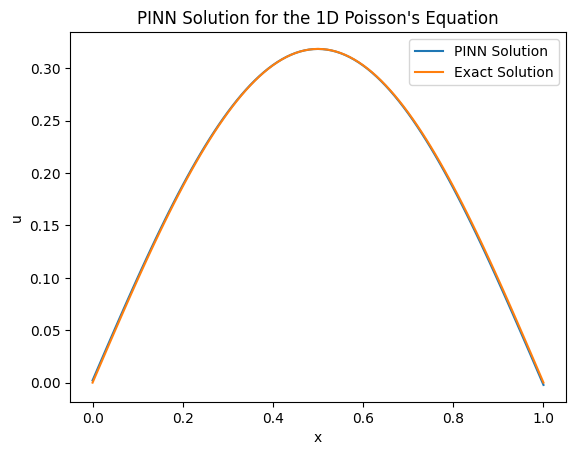

In [7]:
# Plotting
plt.figure()
plt.plot(x_test_1D.numpy(), u_pred_1D, label='PINN Solution')
plt.plot(x_test_1D.numpy(), U_exact_1D, label='Exact Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title('PINN Solution for the 1D Poisson\'s Equation')
plt.legend()
plt.savefig("1d_poisson_equation_approx_exact_solution_pytorch.png")
plt.show()

In [25]:
class Puasson2DPINN(nn.Module):
    def __init__(self, layers, optimizer):
        super(Puasson2DPINN, self).__init__()
        # Creating a list of hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.tanh = nn.Tanh()
        self.optimizer = optimizer

    def forward(self, x1_x2):
        for layer in self.hidden_layers[:-1]:
            x1_x2 = self.tanh(layer(x1_x2))
        x1_x2 = self.hidden_layers[-1](x1_x2)  # No activation after the last layer
        return x1_x2

    def compute_gradients(self, x1_x2):
        x1_x2.requires_grad = True
        
        u = self.forward(x1_x2)
        grad_outputs = torch.ones_like(u)
        grads = torch.autograd.grad(u, x1_x2, grad_outputs=grad_outputs, create_graph=True)[0]  # Note the [0] to get the first tensor
        u_x1, u_x2 = grads[:, 0], grads[:, 1]

        u_x1_x1 = torch.autograd.grad(u_x1, x1_x2, grad_outputs=torch.ones_like(u_x1), create_graph=True)[0][:, 0]
        u_x2_x2 = torch.autograd.grad(u_x2, x1_x2, grad_outputs=torch.ones_like(u_x2), create_graph=True)[0][:, 1]

        return u, u_x1, u_x2, u_x1_x1, u_x2_x2

    def dirichlet_condition(self, x1_x2_bc_up_down, u_bc_up, u_bc_down):
        u, _, _, _, _ = self.compute_gradients(x1_x2_bc_up_down)
        # Assuming u_bc_up and u_bc_down are each of shape [10, 1] and need to be concatenated to match u's shape
        u_bc_combined = torch.cat((u_bc_up, u_bc_down), dim=0)  # Adjust this line as necessary
        return torch.mean(torch.square(u - u_bc_combined))

    def neuman_condition(self, x1_x2_bc_left_right):
        _, u_x1, _, _, _ = self.compute_gradients(x1_x2_bc_left_right)
        return torch.mean(torch.square(u_x1)) # Assuming specific boundary condition implementation

    def loss_fn(self, x1_x2_train, u_x1_x1, u_x2_x2, x1_x2_bc_left_right, x1_x2_bc_up_down, u_bc_up, u_bc_down):
        _, _, _, u_x1_x1_pred, u_x2_x2_pred = self.compute_gradients(x1_x2_train)
        puasson_eq = u_x1_x1_pred + u_x2_x2_pred - self.f(x1_x2_train)
        bc_dirichlet = self.dirichlet_condition(x1_x2_bc_up_down, u_bc_up, u_bc_down)
        bc_neuman = self.neuman_condition(x1_x2_bc_left_right)

        return torch.mean(torch.square(puasson_eq)) + 2 * (bc_dirichlet + bc_neuman)

    def train_loop(self, loss_threshold, x1_x2_train, x1_x2_bc_left_right, x1_x2_bc_up_down, u_bc_up, u_bc_down):
        loss_array = []
        start_time = time.time()

        loss = torch.tensor(1.0)
        epoch = 0
        while loss.item() > loss_threshold:
            self.optimizer.zero_grad()
            loss = self.loss_fn(x1_x2_train, None, None, x1_x2_bc_left_right, x1_x2_bc_up_down, u_bc_up, u_bc_down)
            loss.backward()
            self.optimizer.step()

            loss_array.append(loss.item())
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')
            epoch += 1

        print("Training took %s seconds" % (time.time() - start_time))
        print(f"Last epoch: {epoch}, loss: {loss.item()}")

        plt.plot(loss_array)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid()
        plt.title('Mean loss during training')
        plt.savefig("2d_poisson_equation_training.png")
        plt.show(block=False)

    def f(self, x1_x2):
        x1, x2 = x1_x2[:, 0], x1_x2[:, 1]
        return -np.pi * torch.sin(np.pi * x1) * torch.sin(np.pi * x2)

Epoch 0, Loss: 2.084228515625
Epoch 100, Loss: 0.5857145190238953
Epoch 200, Loss: 0.08327627182006836
Epoch 300, Loss: 0.023426400497555733
Epoch 400, Loss: 0.015429139137268066
Epoch 500, Loss: 0.010688865557312965
Epoch 600, Loss: 0.007640173193067312
Epoch 700, Loss: 0.006445074453949928
Epoch 800, Loss: 0.00836263969540596
Epoch 900, Loss: 0.005055087618529797
Epoch 1000, Loss: 0.004550500772893429
Epoch 1100, Loss: 0.004083534702658653
Epoch 1200, Loss: 0.005186391994357109
Epoch 1300, Loss: 0.003224075073376298
Epoch 1400, Loss: 0.0028574734460562468
Epoch 1500, Loss: 0.002593480981886387
Epoch 1600, Loss: 0.0022717940155416727
Epoch 1700, Loss: 0.0020770274568349123
Epoch 1800, Loss: 0.001977493055164814
Epoch 1900, Loss: 0.001733693410642445
Epoch 2000, Loss: 0.0017317694146186113
Epoch 2100, Loss: 0.001508710440248251
Epoch 2200, Loss: 0.001431265496648848
Epoch 2300, Loss: 0.0016281591961160302
Epoch 2400, Loss: 0.0012696111807599664
Epoch 2500, Loss: 0.001398606924340129
Ep

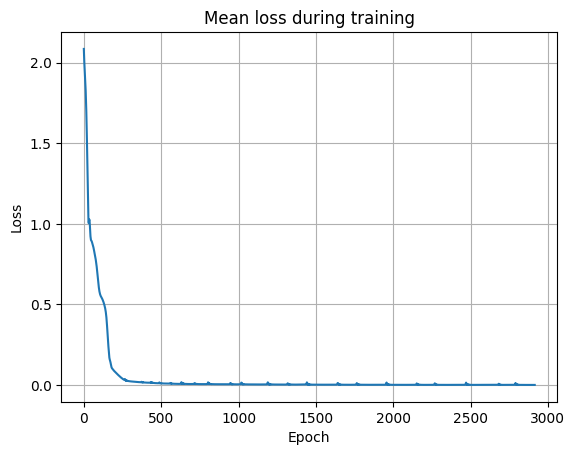

In [26]:
# Constants
N_of_train_points_2D = 10
N_of_test_points_2D = 101
L_x1_2D = 0.0
R_x1_2D = 1.0
L_x2_2D = 0.0
R_x2_2D = 1.0
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 0.001
Layers_2D = [2, 10, 10, 10, 1]  # Adjusted for PyTorch: (input_size, output_size)
Learning_rate_2D = 0.005

# Initialize model and optimizer
model_2D = Puasson2DPINN(Layers_2D, None)  # Optimizer will be set up separately
optimizer_2D = optim.Adam(model_2D.parameters(), lr=Learning_rate_2D)
model_2D.optimizer = optimizer_2D  # Assuming your class can accept an optimizer like this

# Training and test data preparation
x1_train = torch.linspace(L_x1_2D, R_x1_2D, N_of_train_points_2D).unsqueeze(1)
x2_train = torch.linspace(L_x2_2D, R_x2_2D, N_of_train_points_2D).unsqueeze(1)
x1_mesh, x2_mesh = torch.meshgrid(x1_train.squeeze(), x2_train.squeeze(), indexing='ij')
x1_x2_train = torch.hstack((x1_mesh.flatten().unsqueeze(1), x2_mesh.flatten().unsqueeze(1)))

# Boundary conditions preparation
# bc - boundary condition (left and right) neuman
#         __________________________
#         ||                       ||
# [-1, 0] || x2                    || [1, 0] 
#         ||          x1           ||
#         ||_______________________||
# ∂u/∂n = -∂u/∂x1                      ∂u/∂n = ∂u/∂x1
x1_bc_left = L_x1_2D * torch.ones_like(x2_train)
x1_bc_right = R_x1_2D * torch.ones_like(x2_train)
x1_x2_bc_left_right = torch.hstack((torch.cat((x1_bc_left, x1_bc_right)), torch.cat((x2_train, x2_train))))

# bc - boundary condition (up and down) dirichlet
#          [0, 1]  ∂u/∂n = ∂u/∂x2
#  =======================
# |                       |
# | x2                    |
# |          x1           |
# |=======================|
#          [0, -1]  ∂u/∂n = -∂u/∂x2
x2_bc_up = L_x1_2D * torch.ones_like(x1_train)
x2_bc_down = R_x1_2D * torch.ones_like(x1_train)
x1_x2_bc_up_down = torch.hstack((torch.cat((x1_train, x1_train)), torch.cat((x2_bc_up, x2_bc_down))))

u_bc_up = Dirichlet_up_2D * torch.ones_like(x1_train)
u_bc_down = Dirichlet_down_2D * torch.ones_like(x1_train)

# Training
model_2D.train_loop(loss_threshold_2D, x1_x2_train, x1_x2_bc_left_right, x1_x2_bc_up_down, u_bc_up, u_bc_down)

In [30]:
def save_and_load_model_2D(model, layers, optimizer_cls, optimizer_kwargs, fileName):
    # Ensure the model is on the CPU for saving
    model.to('cpu')
    
    # Save model state dictionary
    torch.save(model.state_dict(), f'{fileName}.pt')

    # Instantiate a new model with the same configuration
    new_model = Puasson2DPINN(layers, optimizer_cls(**optimizer_kwargs))

    # Load the state dict into the new model
    new_model.load_state_dict(torch.load(f'{fileName}.pt'))

    # Make sure to call .eval() if you're loading the model for inference
    new_model.eval()

    return new_model

#save_and_load_model_2D(model, layers)

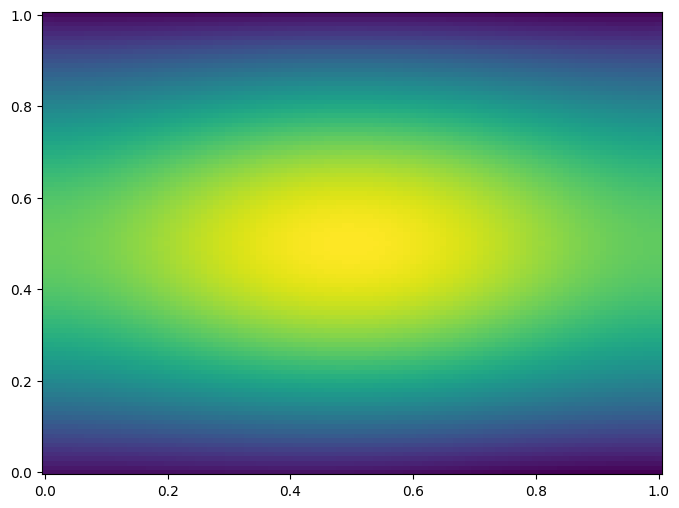

In [27]:
# Assuming L_x1_2D, R_x1_2D, L_x2_2D, R_x2_2D, and N_of_test_points_2D are predefined
x1_test = np.linspace(L_x1_2D, R_x1_2D, N_of_test_points_2D)
x2_test = np.linspace(L_x2_2D, R_x2_2D, N_of_test_points_2D)
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)
x1x2_test = np.hstack((x1_mesh.flatten()[:, np.newaxis], x2_mesh.flatten()[:, np.newaxis]))

# Convert numpy arrays to PyTorch tensors
x1x2_test_tensor = torch.tensor(x1x2_test, dtype=torch.float32)

# Make sure the model is in evaluation mode
model_2D.eval()

# Get predictions from the model
with torch.no_grad():
    u_pred_tensor = model_2D(x1x2_test_tensor)

# Reshape the predictions to match the meshgrid shape
u_pred = u_pred_tensor.reshape(x1_test.shape[0], x2_test.shape[0]).numpy()

# Visualization code remains largely the same
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pred, cmap='viridis')

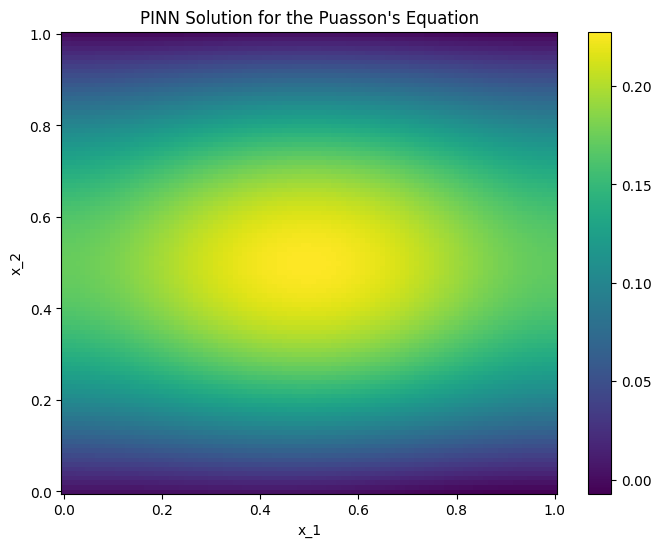

In [28]:
# Visualization
plt.figure(figsize=(8, 6))
plt.pcolor(x1_mesh, x2_mesh, u_pred, cmap='viridis')
plt.colorbar()
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.title("PINN Solution for the Puasson's Equation")
plt.savefig("2d_poisson_equation_exact_solution_heatmap_pytorch.png")
plt.show(block=False)

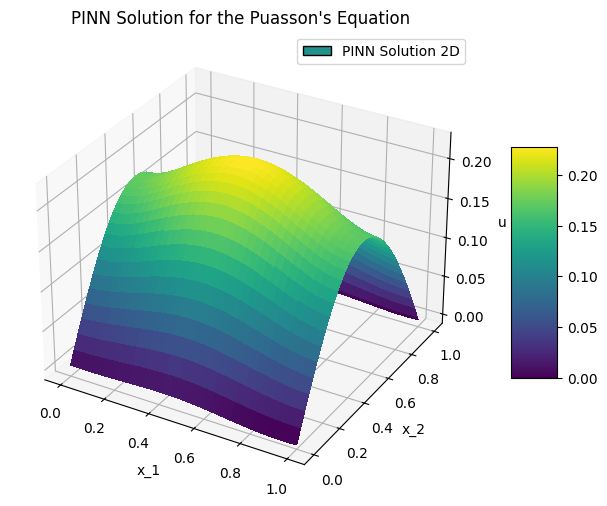

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x1_mesh, x2_mesh, u_pred, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('u')
ax.set_title("PINN Solution for the Puasson's Equation")
color_for_legend = cm.viridis(0.5)
proxy = Rectangle((0, 0), 1, 1, fc=color_for_legend, edgecolor="k")
ax.legend([proxy], ['PINN Solution 2D'])
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("2d_poisson_equation_approx_solution_pytorch.png")
plt.show()

In [ ]:
print("Solving useing FEM")
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Create mesh and define function space
nx, ny = N_of_train_points_2D, N_of_train_points_2D
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary conditions
def boundary_upper(x, on_boundary):
    return on_boundary and near(x[1], R_x1_2D)

def boundary_lower(x, on_boundary):
    return on_boundary and near(x[1], L_x1_2D)

bc_upper = DirichletBC(V, Constant(Dirichlet_up_2D), boundary_upper)
bc_lower = DirichletBC(V, Constant(Dirichlet_down_2D), boundary_lower)

bcs = [bc_upper, bc_lower]

# Define problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('-pi * sin(pi * x[0]) * sin(pi * x[1])', degree=2)
a = -dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bcs)

# Plot solution using matplotlib
c = plot(u)
plt.colorbar(c)
plt.title("FEM solution of Laplace's equation")
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('fenics_solution_half_dirichlet_Laplace_heatmap.png')
plt.show()

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(L_x1_2D, R_x1_2D, N_of_test_points_2D)
y = np.linspace(L_x2_2D, R_x2_2D, N_of_test_points_2D)
X, Y = np.meshgrid(x, y)
points = np.vstack((X.ravel(), Y.ravel())).T

# Initialize an array to store the solution
u_fenics = np.zeros_like(points[:, 0])

# Evaluate the FEniCS solution at each point
for i, point in enumerate(points):
    u_fenics[i] = u(point)

# Reshape the solution to a 2D grid for plotting or comparison
u_fenics_grid = u_fenics.reshape((len(x), len(y)))

surf = ax.plot_surface(X, Y, u_fenics_grid, cmap='viridis', edgecolor='k')
plt.colorbar(surf)
plt.title("3D plot of the solution")
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('u')
plt.savefig('fenics_solution_half_dirichlet_Laplace_3D.png')
plt.show()

print("Mean Squared Error (PINN and FEM):", np.mean((u_fenics_grid - u_pred)**2))

relative_error = calculate_max_relative_error(u_fenics_grid, u_pred)
print(f"Relative error (PINN and FEM): {relative_error:.2f}%")